<a href="https://colab.research.google.com/github/amrios80/linear-regression-tutorial/blob/master/aptos/aptos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Regression

MINE-4101: Applied Data Science  
Univerisdad de los Andes  

**Contexto de Negocio:** La empresa Inmobiliaria Metro Cuadrado domicialada en la ciudad de Bogota - Colombia, quiere brindar a sus clientes una herramienta que les permita estimar el valor de un apartamento de acuerdo a sus caracteristicas fisicas y de ubicacion. El valor estimado debe ser lo mas cercano posible a la realidad para evitar labores de peritaje en el proceso de compra.

**Identificacion de la solución:** La necesidad de negocio planteada puede solucionarse utilizando un algoritmo de manchine learning como regresion lineal dado que se requiere predicir un valor numerico (precio de venta) y contamos con informacion de mercado que nos indica el valor real de los apartamentos de acuerdo a sus caracteristicas.

In [100]:
import numpy as np
import pandas as pd

from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import scipy.stats as stats
import statsmodels.api as sm

In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 50)
pd.set_option('display.float_format', '{:.2f}'.format)

## **1. Carga de los datos**

In [3]:
dataset_url="https://github.com/amrios80/linear-regression-tutorial/raw/refs/heads/master/crabs/data/apartamentos.zip"
apto_df = pd.read_csv(dataset_url, compression="zip")

## **2. Entendimiento y limpieza de los datos**

Dado el contexto de negocio e interpretacion de los datos, se identifica que la variable PRECIO_VENTA es la variable objetivo del modelo de regresion lineal a desarrollar y se utilizaran todas las variables numericas, en cuanto a las variables categoricas consideraremos dentro del analisis SECTOR, ESTADO, ANTIGUEDAD previo conversion a valores numericos utilizando la tecnica de label encoding.

### **2.1 Entendimiento de los datos**

In [4]:
apto_df.shape

(43013, 46)

In [5]:
apto_df.dtypes

_id                         object
codigo                      object
tipo_propiedad              object
tipo_operacion              object
precio_venta               float64
area                       float64
habitaciones               float64
banos                      float64
administracion             float64
parqueaderos               float64
sector                      object
estrato                    float64
antiguedad                  object
latitud                    float64
longitud                   float64
direccion                   object
descripcion                 object
website                     object
last_view                   object
datetime                    object
url                         object
timeline                    object
estado                      object
compañia                    object
precio_arriendo            float64
jacuzzi                    float64
piso                       float64
closets                    float64
chimenea                   float64
permite_mascotas           float64
gimnasio                   float64
ascensor                   float64
conjunto_cerrado           float64
piscina                    float64
salon_comunal              float64
terraza                    float64
vigilancia                 float64
coords_modified               bool
localidad                   object
barrio                      object
estacion_tm_cercana         object
distancia_estacion_tm_m    float64
is_cerca_estacion_tm         int64
parque_cercano              object
distancia_parque_m         float64
is_cerca_parque              int64
dtype: object

In [6]:
apto_df.sample(3)

_id          codigo tipo_propiedad tipo_operacion  \
37715  66d86e47ceda690e85511ab3   3390-M3312148    APARTAMENTO          VENTA   
29526  66d86da8ceda690e8550fab6  12041-M4548977    APARTAMENTO          VENTA   
29680  66d86dabceda690e8550fb50       MC4769980    APARTAMENTO          VENTA   

       precio_venta   area  habitaciones  banos  administracion  parqueaderos  \
37715 1620000000.00 245.00          4.00   5.00      1400000.00          3.00   
29526 1290000000.00 224.00          4.00   5.00      1260000.00          2.00   
29680  399000000.00  57.10          2.00   2.00       335000.00          1.00   

              sector  estrato          antiguedad  latitud  longitud  \
37715  SANTA BARBARA     6.00  ENTRE 10 Y 20 ANOS     4.69    -74.05   
29526  SANTA BARBARA     6.00      MAS DE 20 ANOS     4.69    -74.05   
29680      ORQUIDEAS     4.00    ENTRE 0 Y 5 ANOS     4.75    -74.03   

      direccion                                        descripcion  \
37715       NaN  apartamento duplex en venta en chico navarra c...   
29526       NaN  espectacular apartamento exterior en venta, ub...   
29680       NaN  excelente apartamento de 2 habitaciones,2 bano...   

                 website                last_view                 datetime  \
37715  metrocuadrado.com  2024-08-13 13:16:26.912  2024-08-13 13:16:26.912   
29526  metrocuadrado.com  2024-08-08 22:27:41.779  2024-08-02 02:09:07.507   
29680  metrocuadrado.com  2024-08-13 18:25:45.064  2024-08-02 02:36:01.446   

       url timeline estado              compañia  precio_arriendo  jacuzzi  \
37715  NaN      NaN  USADO            COOL HOUSE              NaN     0.00   
29526  NaN       []  USADO  OLINDA BIENES RAICES              NaN     0.00   
29680  NaN       []  USADO                   NaN              NaN     0.00   

       piso  closets  chimenea  permite_mascotas  gimnasio  ascensor  \
37715   NaN      NaN      0.00              0.00      0.00      1.00   
29526   NaN      NaN      0.00              0.00      0.00      1.00   
29680   NaN      NaN      0.00              0.00      0.00      1.00   

       conjunto_cerrado  piscina  salon_comunal  terraza  vigilancia  \
37715              1.00     0.00           0.00     0.00        1.00   
29526              0.00     0.00           0.00     0.00        1.00   
29680              0.00     1.00           0.00     0.00        0.00   

       coords_modified localidad              barrio  \
37715            False   USAQUEN       SANTA BIBIANA   
29526            False   USAQUEN    RINCON DEL CHICO   
29680            False   USAQUEN  LA GRANJA ORIENTAL   

            estacion_tm_cercana  distancia_estacion_tm_m  \
37715                 Calle 106                   704.11   
29526  Calle 100 - Marketmedios                  1411.87   
29680              Portal Norte                  1814.46   

       is_cerca_estacion_tm  \
37715                     0   
29526                     0   
29680                     0   

                                          parque_cercano  distancia_parque_m  \
37715  PARQUE VECINAL URBANIZACIÓN NORMANDIA I II II ...             1455.77   
29526              PARQUE ZONAL CANAL EL VIRREY EL CHICO             1630.35   
29680    PARQUE VECINAL URBANIZACIÓN CALLE 170 / ALAMEDA              960.89   

       is_cerca_parque  
37715                0  
29526                0  
29680                0

##### **2.1.1 Tipos de Operacion y Tipo de Propiedad**: Identificamos en el dataset operaciones diferentes a VENTA, exploramos las operaciones existentes y eliminamos la operacion ARRIENDO ya que no corresponde al objetivo del estudio, en cuanto al tipo de propiedad, se consideran los apartamentos y se excluyen las casas.

In [7]:
apto_df["tipo_operacion"].value_counts()

tipo_operacion
VENTA               27270
ARRIENDO            15515
VENTA Y ARRIENDO      228
Name: count, dtype: int64

In [8]:
apto_df=apto_df[(apto_df["tipo_operacion"] == "VENTA") | (apto_df["tipo_operacion"]=="VENTA Y ARRIENDO")]

In [9]:
apto_df["tipo_operacion"].value_counts()

tipo_operacion
VENTA               27270
VENTA Y ARRIENDO      228
Name: count, dtype: int64

In [10]:
apto_df["tipo_propiedad"].value_counts()

tipo_propiedad
APARTAMENTO                  27428
CASA CON CONJUNTO CERRADO       60
CASA                            10
Name: count, dtype: int64

In [11]:
apto_df=apto_df[(apto_df["tipo_propiedad"] == "APARTAMENTO")]

In [12]:
apto_df["tipo_propiedad"].value_counts()

tipo_propiedad
APARTAMENTO    27428
Name: count, dtype: int64

##### **2.1.2 Medidas de tendencia central y dispercion de la variable PRECIO_VENTA**: Identificamos que la variable precio tiene una alta dispersion ya que la desviacion estandar esta por encima de la media, los precios de venta en el dataset varian entre 1'000.000 y 4.250.000'000.000, es posible que el precio minimo corresponda a una inconsistencia en los datos ya que el valor es consecuente con un canon de arrendamiento mas no con el precio de venta de un apartamento, el precio maximo es muy alto con respecto al valor maximo del 75% de la oferta de apartamentos que es de 1.340'000.000

In [13]:
apto_df["precio_venta"].describe()

count           27428.00
mean       2375589728.70
std       55900056661.84
min           1000000.00
25%         410000000.00
50%         710000000.00
75%        1350000000.00
max     4250000000000.00
Name: precio_venta, dtype: float64

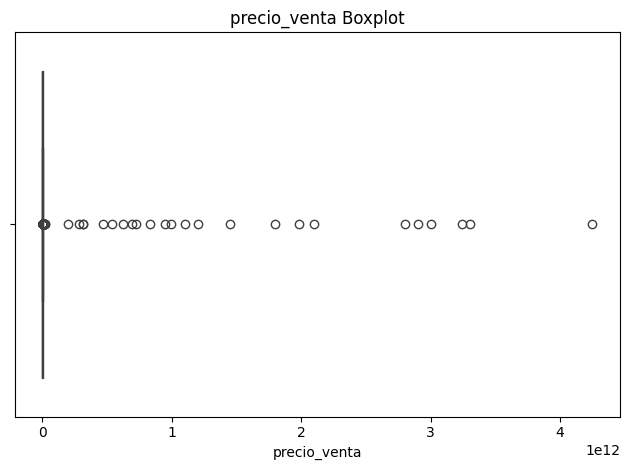

In [14]:
def boxplot(apto_df , field="precio_venta"):
  plt.xlabel(field)
  sns.boxplot(x=apto_df[field])
  plt.title(f'{field} Boxplot')
  plt.xlabel(field)
  plt.tight_layout()
  plt.show()

boxplot(apto_df, field="precio_venta")

##### **2.1.3 Eliminar valores atipicos de la variable PRECIO_VENTA**: Removiendo los valores atipicos los valores minimos y maximos fluctuan entre  171'500.000 COP y 1.570'000.000 COP, la desviacion estandar es menor que el promedio y el valor promedio de los apartamentos es de 676.955.510 COP consideramos que esta información esta mas acorde con la realidad del mercado.

In [15]:
def cut_outliers_from_df(df0 , field="precio_venta", iqr_pct=0.25):
  df=df0.copy()
  if pd.api.types.is_numeric_dtype(df[field]):
     q1 = df[field].quantile(0.25)
     q3 = df[field].quantile(0.75)
     iqr = q3 - q1
     lower_bound = q1 - (iqr_pct * iqr)
     upper_bound = q3 + (iqr_pct * iqr)
     df=df[(df[field] >= lower_bound) & (df[field] <= upper_bound)]
  return df

In [16]:
df=cut_outliers_from_df(apto_df, field="precio_venta")
apto_df=df
apto_df["precio_venta"].describe()


count        21070.00
mean     681246143.43
std      365767799.31
min      175000000.00
25%      389462500.00
50%      596300000.00
75%      904400000.00
max     1585000000.00
Name: precio_venta, dtype: float64

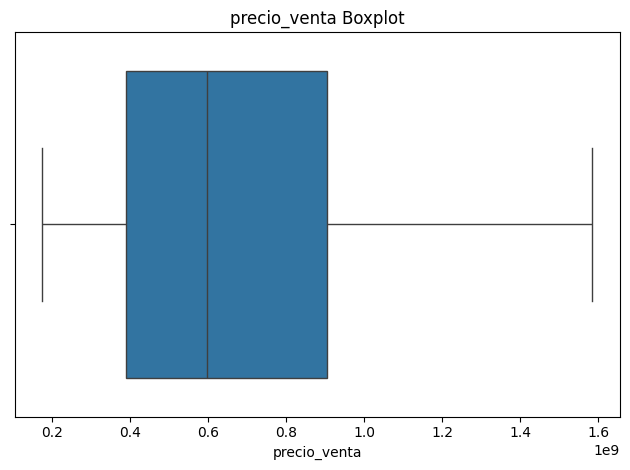

In [17]:
def boxplot(apto_df , field="precio_venta"):
  plt.xlabel(field)
  sns.boxplot(x=apto_df[field])
  plt.title(f'{field} Boxplot')
  plt.xlabel(field)
  plt.tight_layout()
  plt.show()

boxplot(apto_df, field="precio_venta")

##### **2.1.4 Exploracion variables categoricas ANTIGUEDAD, ESTADO y SECTOR**: Del total de la oferta de apartamentos en venta analizados (20.634), cerca del 65% tienen una antiguedad mayor a 10 años (13.277). El 1% de los apartamentos son NUEVOS. El 80% de la oferta de apartamentos se concentra en los siguientes sectores: SANTA BARBARA, CHICO, COLINA Y ALREDEDORES, COUNTRY, CEDRITOS, NIZA ALHAMBRA, CHAPINERO ALTO, ORQUIDEAS, SALITRE MODELIA, ALTOS DE SUBA Y CERROS DE SAN JORGE.

In [18]:
apto_df["antiguedad"].value_counts()

antiguedad
MAS DE 20 ANOS        7677
ENTRE 10 Y 20 ANOS    5558
ENTRE 0 Y 5 ANOS      3585
ENTRE 5 Y 10 ANOS     3335
REMODELADO             690
SOBRE PLANOS           106
EN CONSTRUCCION         96
PARA ESTRENAR           16
Name: count, dtype: int64

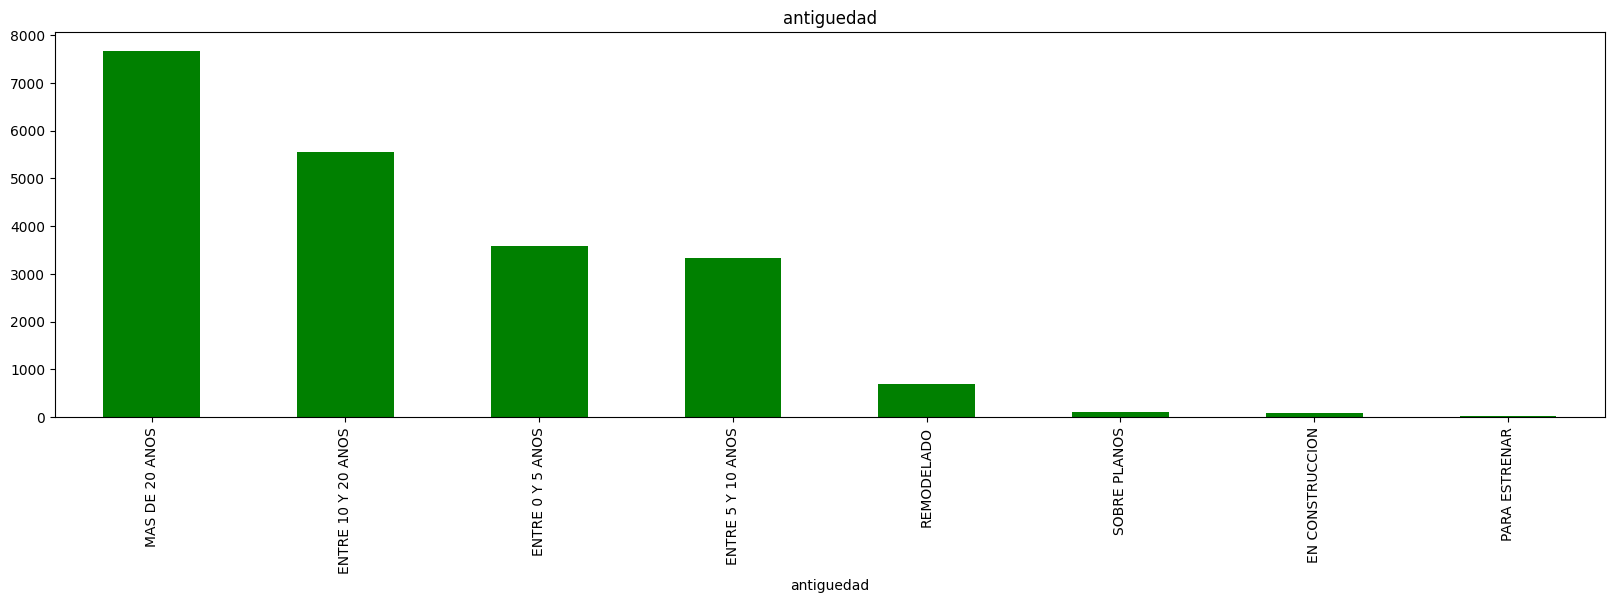

In [19]:
fig, (ax1) = plt.subplots(1, sharey=True, figsize=(20, 5))
apto_df["antiguedad"].value_counts().plot(kind="bar", ax=ax1, color="green")
ax1.set_title("antiguedad")
plt.show()

In [20]:
apto_df["estado"].value_counts()

estado
USADO    20422
NUEVO      218
Name: count, dtype: int64

In [21]:
sector_frec_cumsum = apto_df["sector"].value_counts(normalize=True).cumsum()
most_representative_sector = sector_frec_cumsum.loc[sector_frec_cumsum < 0.8].index.tolist()
most_representative_sector

['SANTA BARBARA',
 'CHICO',
 'COLINA Y ALREDEDORES',
 'COUNTRY',
 'CEDRITOS',
 'NIZA ALHAMBRA',
 'CHAPINERO ALTO',
 'ORQUIDEAS',
 'SALITRE MODELIA',
 'ALTOS DE SUBA Y CERROS DE SAN JORGE']

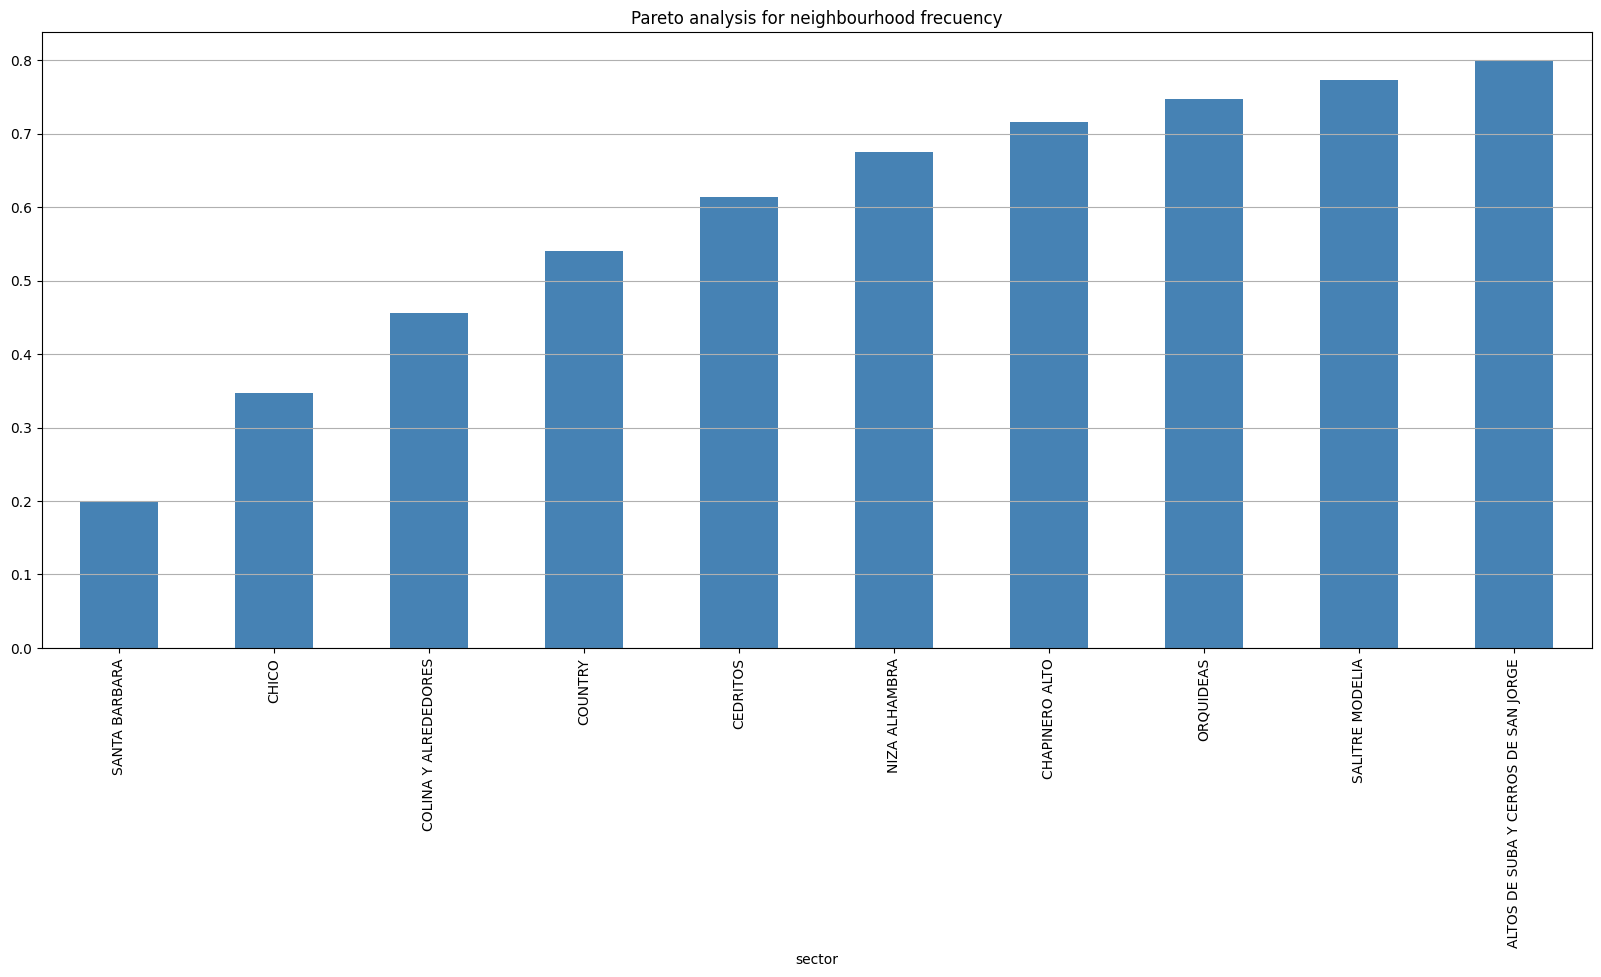

In [22]:
plt.figure(figsize=(20, 8))
sector_frec_cumsum.loc[sector_frec_cumsum < 0.8].plot(kind="bar", color="steelblue")
plt.title("Pareto analysis for neighbourhood frecuency")
plt.grid(axis="y")
plt.show()

##### **2.1.5 Crear dataset de entrada al modelo:** Se identifican las variables categoricas, numericas (features) y variable objetivo (target) para generar el dataset que se utilizara en el analisis. No se tienen en cuenta las variables de entrada que tienen similitud y/o que son representan el detalle de otra.

In [23]:
numeric_vars = ["area", "habitaciones", "banos", "administracion", "parqueaderos", "estrato", "jacuzzi","piso","closets", "chimenea", "permite_mascotas","gimnasio", "ascensor","piscina","salon_comunal","terraza","vigilancia","distancia_estacion_tm_m","distancia_parque_m", "is_cerca_parque","conjunto_cerrado"]
category_vars = ["tipo_propiedad", "sector", "antiguedad", "estado", "localidad","compañia","barrio","estacion_tm_cercana","parque_cercano"]
target_var="precio_venta"
features=numeric_vars + category_vars

In [24]:
# Se define funcion para transformar las variables categoricas a numericas
def get_df(df, target_var="target", numeric_vars=[], category_vars=[]):
  df = df.copy()
  label_encoder = LabelEncoder()
  for col in category_vars:
      df[col] = label_encoder.fit_transform(df[col].astype(str))
  df=df[ numeric_vars + category_vars+ [target_var]]
  return df

In [25]:
# Se crea el dataset df con las variables de entrada mas la variable objetivo
df = get_df(apto_df,"precio_venta" ,numeric_vars, category_vars)

In [26]:
df.sample(3)

area  habitaciones  banos  administracion  parqueaderos  estrato  \
5031   81.83          2.00   2.00       980000.00          1.00     6.00   
27504  96.64          3.00   3.00       465000.00          1.00     4.00   
7262  120.00          3.00   3.00       598000.00          2.00     6.00   

       jacuzzi  piso  closets  chimenea  permite_mascotas  gimnasio  ascensor  \
5031      0.00   NaN      NaN      0.00              0.00      0.00      1.00   
27504     0.00   NaN      NaN      0.00              0.00      0.00      1.00   
7262      0.00   NaN      NaN      0.00              0.00      1.00      0.00   

       piscina  salon_comunal  terraza  vigilancia  distancia_estacion_tm_m  \
5031      0.00           0.00     0.00        0.00                   810.01   
27504     0.00           0.00     0.00        1.00                   483.59   
7262      0.00           0.00     0.00        1.00                   559.43   

       distancia_parque_m  is_cerca_parque  conjunto_cerrado  tipo_propiedad  \
5031               804.60                0              0.00               0   
27504              382.71                1              0.00               0   
7262              1022.65                0              0.00               0   

       sector  antiguedad  estado  localidad  compañia  barrio  \
5031       25           4       1          4       359     753   
27504      64           4       1         14       368     475   
7262       32           4       1         17       124    1206   

       estacion_tm_cercana  parque_cercano  precio_venta  
5031                    22              98  550000000.00  
27504                   67              97  575000000.00  
7262                   106              90  700000000.00

##### **2.1.6 Eliminacion de columnas sin informacion, valores nulos del dataset y valores en 0 de la variable objetivo:**  Se identifican las columnas con valores nulos para hacer limpieza del dataset. Las variables de entrada piso y closets no traen informacion, no es posible realizar imputacion de datos por lo que se decide quitar estas columnas

In [27]:
# Encuentra el porcentaje de nulos por columna
df[[target_var]+features].isnull().sum() / df.shape[0]

precio_venta              0.00
area                      0.00
habitaciones              0.00
banos                     0.00
administracion            0.09
parqueaderos              0.00
estrato                   0.00
jacuzzi                   0.00
piso                      1.00
closets                   1.00
chimenea                  0.00
permite_mascotas          0.00
gimnasio                  0.00
ascensor                  0.00
piscina                   0.00
salon_comunal             0.00
terraza                   0.00
vigilancia                0.00
distancia_estacion_tm_m   0.00
distancia_parque_m        0.00
is_cerca_parque           0.00
conjunto_cerrado          0.00
tipo_propiedad            0.00
sector                    0.00
antiguedad                0.00
estado                    0.00
localidad                 0.00
compañia                  0.00
barrio                    0.00
estacion_tm_cercana       0.00
parque_cercano            0.00
dtype: float64

In [28]:
df.sample(3)

area  habitaciones  banos  administracion  parqueaderos  estrato  \
261    32.00          1.00   1.00       186666.00          0.00     4.00   
2730   98.00          3.00   3.00       105000.00          0.00     4.00   
39197 182.00          3.00   3.00       930000.00          2.00     6.00   

       jacuzzi  piso  closets  chimenea  permite_mascotas  gimnasio  ascensor  \
261       0.00   NaN      NaN      0.00              0.00      1.00      0.00   
2730      0.00   NaN      NaN      0.00              0.00      0.00      0.00   
39197     0.00   NaN      NaN      0.00              0.00      0.00      1.00   

       piscina  salon_comunal  terraza  vigilancia  distancia_estacion_tm_m  \
261       0.00           0.00     1.00        0.00                  2998.86   
2730      0.00           0.00     0.00        0.00                   569.11   
39197     0.00           0.00     0.00        1.00                  1533.78   

       distancia_parque_m  is_cerca_parque  conjunto_cerrado  tipo_propiedad  \
261                773.05                0              1.00               0   
2730               912.09                0              0.00               0   
39197              850.46                0              1.00               0   

       sector  antiguedad  estado  localidad  compañia  barrio  \
261        76           1       2         17       807      69   
2730       24           4       1          4       515     817   
39197      25           4       1          4       680     543   

       estacion_tm_cercana  parque_cercano  precio_venta  
261                     76              89  216000000.00  
2730                    33              22  380000000.00  
39197                   36             114  930000000.00

In [29]:
#Elimina las variables de entrada piso y closets
if "piso" in df.columns:
    df = df.drop(columns=['piso'])
    if "piso" in features:
        features.remove("piso")
if "closets" in df.columns:
    df = df.drop(columns=['closets'])
    if "closets" in features:
        features.remove("closets")

In [30]:
#Validamos que no existan las columnas eliminadas anteriormente
print(df.columns)

Index(['area', 'habitaciones', 'banos', 'administracion', 'parqueaderos',
       'estrato', 'jacuzzi', 'chimenea', 'permite_mascotas', 'gimnasio',
       'ascensor', 'piscina', 'salon_comunal', 'terraza', 'vigilancia',
       'distancia_estacion_tm_m', 'distancia_parque_m', 'is_cerca_parque',
       'conjunto_cerrado', 'tipo_propiedad', 'sector', 'antiguedad', 'estado',
       'localidad', 'compañia', 'barrio', 'estacion_tm_cercana',
       'parque_cercano', 'precio_venta'],
      dtype='object')


In [31]:
# Quita los valores nulos
df = df.dropna(subset=[target_var]+features)
df_clean = df.dropna()
df= df_clean
df.shape

(19235, 29)

In [32]:
# Quita los precios en cero.
df=df[df[target_var]>0]
df.shape

(19235, 29)

### **2.2. Búsqueda de relaciones con la variable objetivo**

Si se logra visualizar o cuantificar altas correlaciones entre las variables de entrada y la variable objetivo, se podrán soportar las decisiones del experto con base en la evidencia.

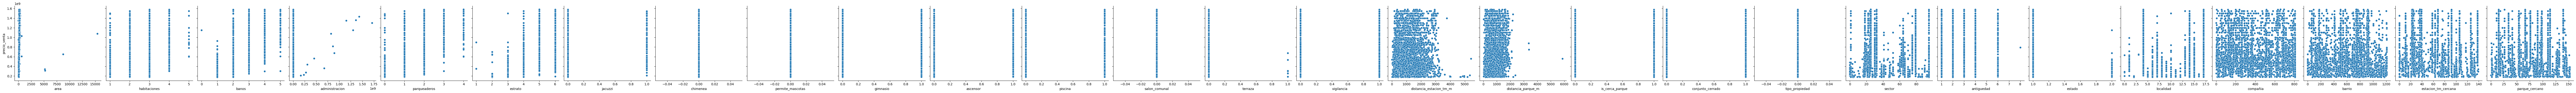

In [33]:
sns.pairplot(df.sample(frac=0.2), height=4, y_vars=target_var, x_vars=features, kind="scatter")


#####**2.2.1 Eliminacion de variables de entrada con valor 0:** Se eliminan las variables de entrada: salón comunal, permite mascotas, chimenea ya que todos sus valores estan el 0.

In [34]:
#if "permite_mascotas" in df.columns:
 #   df = df.drop(columns=['permite_mascotas'])
 #   if "permite_mascotas" in features:
 #       features.remove("permite_mascotas")
#if "chimenea" in df.columns:
 #   df = df.drop(columns=['chimenea'])
 #   if "chimenea" in features:
 #       features.remove("chimenea")
#if "salon_comunal" in df.columns:
 #   df = df.drop(columns=['salon_comunal'])
 #   if "salon_comunal" in features:
 #       features.remove("salon_comunal")
#if "tipo_propiedad" in df.columns:
 #   df = df.drop(columns=['tipo_propiedad'])
 #   if "tipo_propiedad" in features:
 #       features.remove("tipo_propiedad")


#####**2.2.2 Observacion variables de entrada Area y Administracion:** Se observan valores atípicos para las variables Area y Administracion y no permiten validar la correlacion entre estas variables y el precio de venta.

In [35]:
def cut_outliers_from_df(df0 , field="price", iqr_pct=0.6):
  df=df0.copy()
  print(f"Statistics for {field}:")
  print("before:")
  print(df[field].describe( percentiles=[0.25, 0.50, 0.75, 0.95]))
  if pd.api.types.is_numeric_dtype(df[field]):
     q1 = df[field].quantile(0.25)
     q3 = df[field].quantile(0.75)
     iqr = q3 - q1
     lower_bound = q1 - (iqr_pct * iqr)
     upper_bound = q3 + (iqr_pct * iqr)
     df=df[(df[field] >= lower_bound) & (df[field] <= upper_bound)]
     print(f"after (iqr):")
     print(df[field].describe( percentiles=[0.25, 0.50, 0.75, 0.95]))
  return df

In [36]:
#Aplica la funcion cut_outliers_from_df para quitar outliers LO APLICA A TODAS LAS VARIABLES DE ENTRADA QUE SON DE INTERES
df2=cut_outliers_from_df(df, field="area")

Statistics for area:
before:
count   19235.00
mean      113.42
std       248.97
min         0.00
25%        67.24
50%        95.80
75%       140.00
95%       208.00
max     19621.00
Name: area, dtype: float64
after (iqr):
count   17354.00
mean       96.68
std        38.85
min        23.62
25%        65.00
50%        90.00
75%       125.20
95%       169.00
max       183.59
Name: area, dtype: float64


In [37]:
df2=cut_outliers_from_df(df2, field="administracion")
df=df2

Statistics for administracion:
before:
count        17354.00
mean       3129888.15
std       44906184.42
min              1.00
25%         310000.00
50%         500000.00
75%         795000.00
95%        1284070.00
max     1600000000.00
Name: administracion, dtype: float64
after (iqr):
count     15474.00
mean     501196.88
std      256756.54
min       20000.00
25%      300000.00
50%      465000.00
75%      692825.00
95%      980000.00
max     1086000.00
Name: administracion, dtype: float64


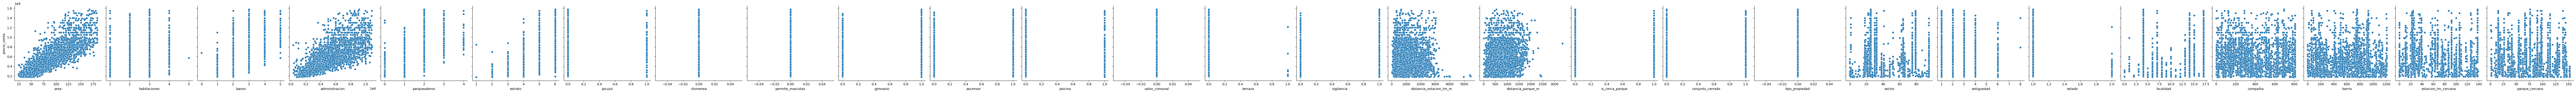

In [38]:
sns.pairplot(df.sample(frac=0.2), height=4, y_vars=target_var, x_vars=features, kind="scatter")

### **2.3 Búsqueda de relaciones entre las variables de entrada**

<Axes: >

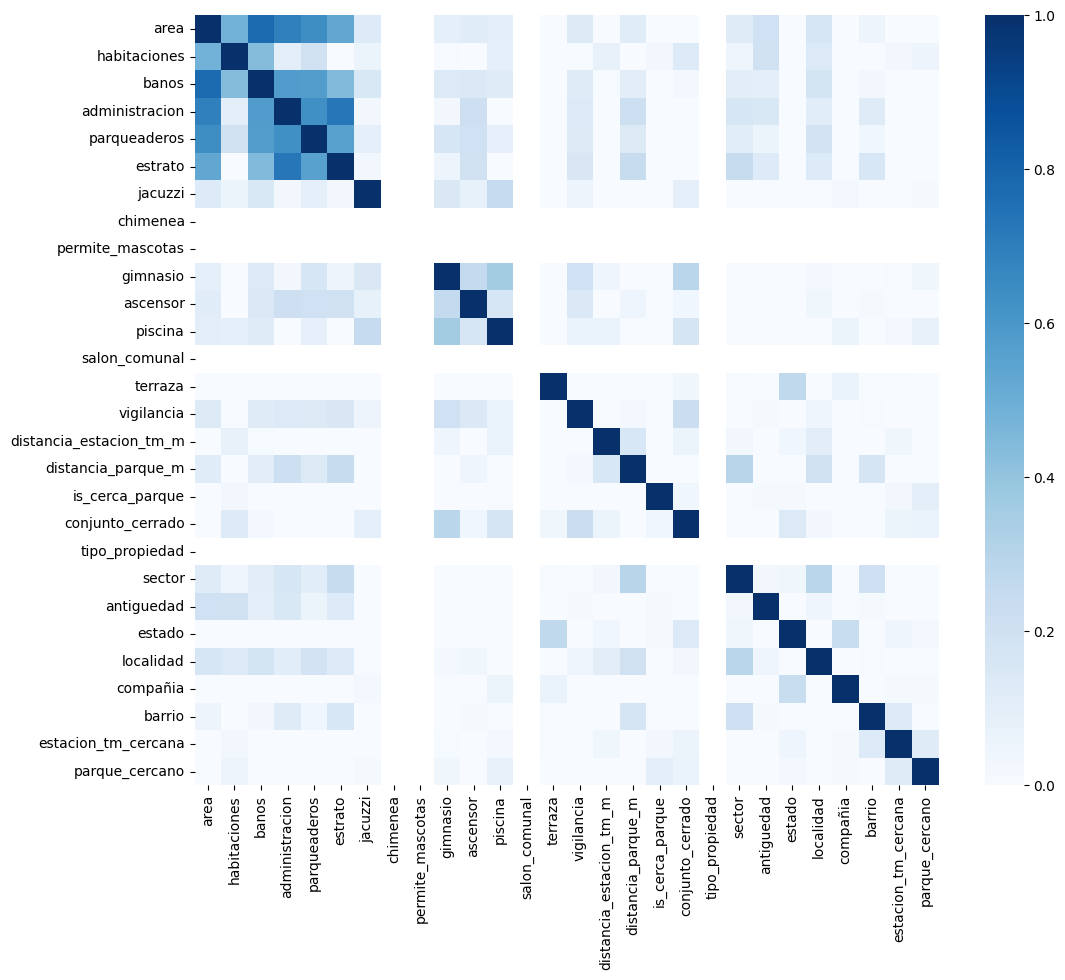

In [39]:
plt.figure(figsize=(12, 10))
sns.heatmap(df[features].corr(), cmap="Blues", vmin=0, vmax=1)

Se observa una correlacion fuerte entre las variables de entrada, banos y parqueaderos asi como tambien estrato con baños y parquederos. Por lo anterior se eliminaran la variables banos y parqueaderos.

In [40]:
#if "banos" in df.columns:
    #df = df.drop(columns=['banos'])
    #if "banos" in features:
        #features.remove("banos")
#if "parqueaderos" in df.columns:
 #   df = df.drop(columns=['parqueaderos'])
 #   if "parqueaderos" in features:
 #       features.remove("parqueaderos")
#if "estrato" in df.columns:
 #   df = df.drop(columns=['estrato'])
 #   if "estrato" in features:
 #       features.remove("estrato")

<Axes: >

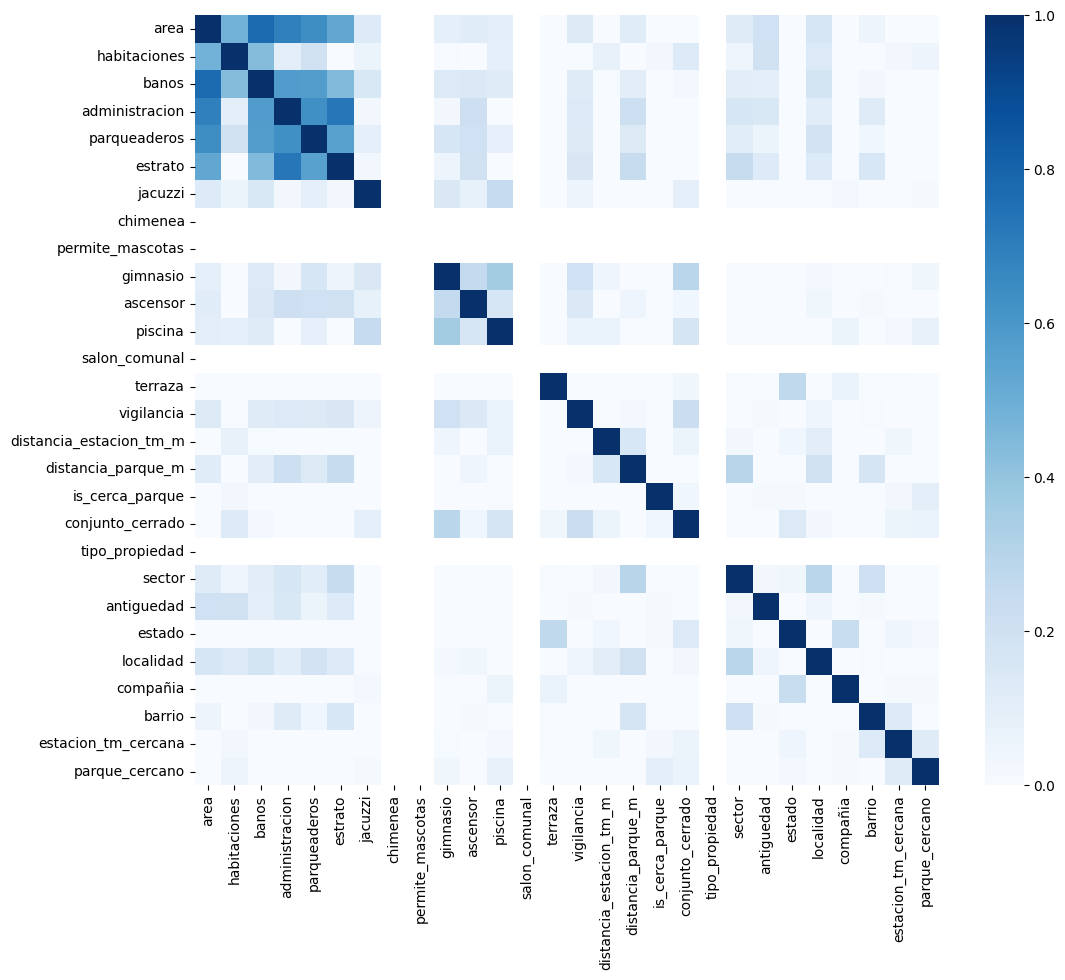

In [41]:
plt.figure(figsize=(12, 10))
sns.heatmap(df[features].corr(), cmap="Blues", vmin=0, vmax=1)

## **3. Preparacion de datos**


In [42]:
total_rows = df.shape[0]
total_rows

15474

In [43]:
df.loc[df.duplicated(subset=features, keep=False)].head(3)

area  habitaciones  banos  administracion  parqueaderos  estrato  \
346  45.00          3.00   1.00       124209.00          0.00     3.00   
605 121.73          3.00   2.00       900000.00          1.00     6.00   
608  59.00          2.00   2.00       400000.00          1.00     3.00   

     jacuzzi  chimenea  permite_mascotas  gimnasio  ascensor  piscina  \
346     0.00      0.00              0.00      0.00      0.00     0.00   
605     0.00      0.00              0.00      0.00      1.00     0.00   
608     0.00      0.00              0.00      1.00      1.00     0.00   

     salon_comunal  terraza  vigilancia  distancia_estacion_tm_m  \
346           0.00     0.00        0.00                   942.74   
605           0.00     0.00        1.00                  1547.06   
608           0.00     0.00        1.00                   894.60   

     distancia_parque_m  is_cerca_parque  conjunto_cerrado  tipo_propiedad  \
346              659.25                0              1.00               0   
605              569.72                0              1.00               0   
608              934.24                0              1.00               0   

     sector  antiguedad  estado  localidad  compañia  barrio  \
346      83           3       2         14       807     845   
605      25           6       1          4       625      91   
608      30           1       1         14       625     664   

     estacion_tm_cercana  parque_cercano  precio_venta  
346                  101              83  195000000.00  
605                   68             139  750000000.00  
608                   86             128  355000000.00

In [44]:
duplicated_rows = df.loc[df.duplicated(subset=features, keep=False)].shape[0]
duplicated_rows

637

In [45]:
print(f"Duplicates: {(duplicated_rows/total_rows)*100:.4f}%")

Duplicates: 4.1166%


In [46]:
df.loc[df.duplicated(subset=features+["precio_venta"], keep=False)].tail(4)

area  habitaciones  banos  administracion  parqueaderos  estrato  \
42792 82.00          2.00   2.00       493000.00          2.00     6.00   
42841 68.00          2.00   2.00       600000.00          1.00     5.00   
42842 68.00          2.00   2.00       600000.00          1.00     5.00   
42894 90.00          3.00   2.00       630000.00          1.00     5.00   

       jacuzzi  chimenea  permite_mascotas  gimnasio  ascensor  piscina  \
42792     0.00      0.00              0.00      0.00      1.00     0.00   
42841     0.00      0.00              0.00      0.00      0.00     0.00   
42842     0.00      0.00              0.00      0.00      0.00     0.00   
42894     0.00      0.00              0.00      0.00      0.00     0.00   

       salon_comunal  terraza  vigilancia  distancia_estacion_tm_m  \
42792           0.00     0.00        0.00                  1379.67   
42841           0.00     0.00        0.00                   372.65   
42842           0.00     0.00        0.00                   372.65   
42894           0.00     0.00        1.00                  1004.44   

       distancia_parque_m  is_cerca_parque  conjunto_cerrado  tipo_propiedad  \
42792             1545.63                0              0.00               0   
42841              615.56                0              0.00               0   
42842              615.56                0              0.00               0   
42894             1010.14                0              1.00               0   

       sector  antiguedad  estado  localidad  compañia  barrio  \
42792      79           4       1         17       621     711   
42841      64           2       1         14       621     682   
42842      64           2       1         14       621     682   
42894      32           4       1         17       776     248   

       estacion_tm_cercana  parque_cercano  precio_venta  
42792                   22              98  480000000.00  
42841                  128             131  480000000.00  
42842                  128             131  480000000.00  
42894                   11              54  450000000.00

In [47]:
duplicated_rows = df.loc[df.duplicated(subset=features+["precio_venta"], keep=False)].shape[0]
duplicated_rows

526

In [48]:
print(f"Duplicates: {(duplicated_rows/total_rows)*100:.4f}%")

Duplicates: 3.3993%


Existe un ~5.2% de registros con variables de entrada duplicadas, incluso con variable objetivo diferente. Al incluir la variable objetivo dentro del análisis de duplicados, se obtiene el ~4% registros duplicados adicionales. Para un porcentaje total de ~9.2%, se decide eliminar los datos duplicados con el fin de no afectar en la funcion de estimacion.

In [49]:
df.drop_duplicates(subset=features, inplace=True)
df.drop_duplicates(subset=features+["precio_venta"], inplace=True)

In [130]:
#HOT ENCODING
#df_one_hot = pd.get_dummies(df, columns=['habitaciones'], prefix='habitaciones')
#df_one_hot.head(3)

In [50]:
df.shape

(15093, 29)

## **4. Particionamiento del conjunto de datos en entrenamiento y prueba**

In [51]:
X_train, X_test, y_train, y_test = train_test_split(df[features], df["precio_venta"], test_size=0.3, random_state=1)

In [52]:
X_train.shape, y_train.shape

((10565, 28), (10565,))

In [53]:
X_test.shape, y_test.shape

((4528, 28), (4528,))

## **5. Entrenamiento de un primer modelo de regresión lineal**

In [54]:
regression = LinearRegression()

In [103]:
regression.fit(X_train, y_train)

LinearRegression()

## **4.1. Interpretación de los coeficientes y del intercepto**


In [56]:
pd.DataFrame({"columns": features, "coef": regression.coef_})

columns         coef
0                      area   4589751.08
1              habitaciones -40271677.56
2                     banos  24268180.05
3            administracion       212.25
4              parqueaderos  44598198.19
5                   estrato  29588884.74
6                   jacuzzi   9809583.00
7                  chimenea        -0.00
8          permite_mascotas         0.00
9                  gimnasio  41685139.76
10                 ascensor    620664.01
11                  piscina  26119118.49
12            salon_comunal         0.00
13                  terraza   9912724.16
14               vigilancia   4128264.60
15  distancia_estacion_tm_m    -11957.63
16       distancia_parque_m      9412.37
17          is_cerca_parque  18321096.88
18         conjunto_cerrado  -5407834.83
19           tipo_propiedad        -0.00
20                   sector    331146.43
21               antiguedad -33780134.53
22                   estado  -6016593.76
23                localidad  -7337325.34
24                 compañia     -8399.79
25                   barrio    -13788.28
26      estacion_tm_cercana     35119.58
27           parque_cercano    -71206.54

In [57]:
regression.intercept_

82151560.42469901

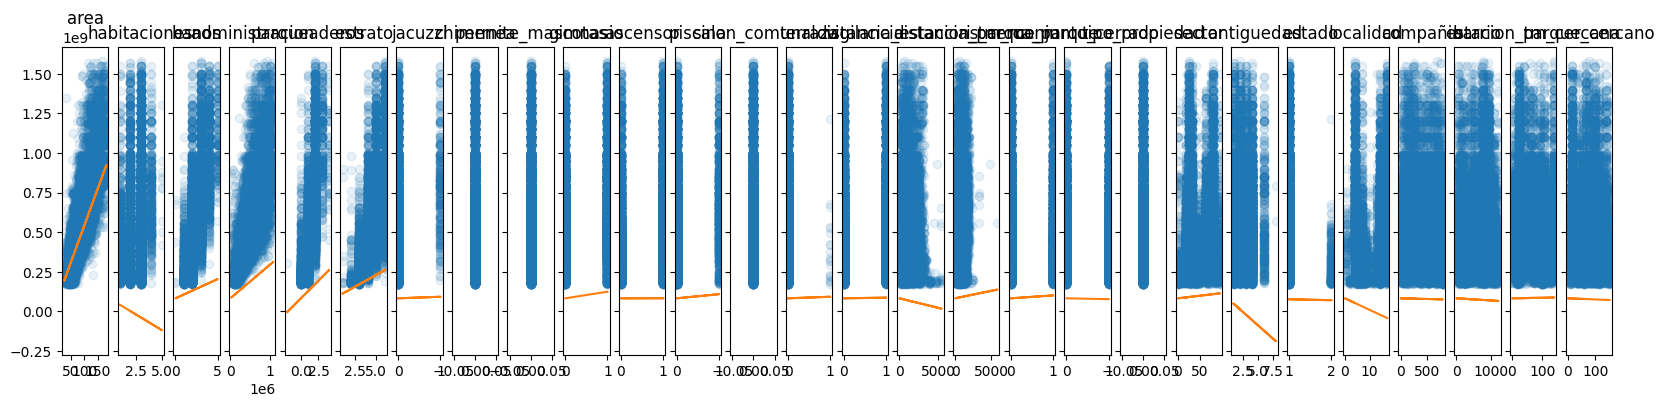

In [58]:
f, axs = plt.subplots(1, len(features), sharey=True, figsize=(20, 4))

for i in range(len(features)):
    col = features[i]
    x = X_train[col]
    m = regression.coef_[i]
    b = regression.intercept_

    axs[i].plot(x, y_train, "o", alpha=0.1)
    axs[i].plot(x, x * m + b)
    axs[i].set_title(col)

## **4.2. Validación (evaluación) del modelo**

**Mean Absolute Error (MAE)**

In [59]:
print("Train:", mean_absolute_error(y_train, regression.predict(X_train)))
print("Test:", mean_absolute_error(y_test, regression.predict(X_test)))



Train: 88070013.50984165
Test: 89712114.48224267


**Root Mean Squeared Error (RMSE)**

In [60]:
print("Train:", np.sqrt(mean_squared_error(y_train, regression.predict(X_train))))
print("Test:", np.sqrt(mean_squared_error(y_test, regression.predict(X_test))))

Train: 121284146.11280265
Test: 123909598.2404707


**Análisis del error**

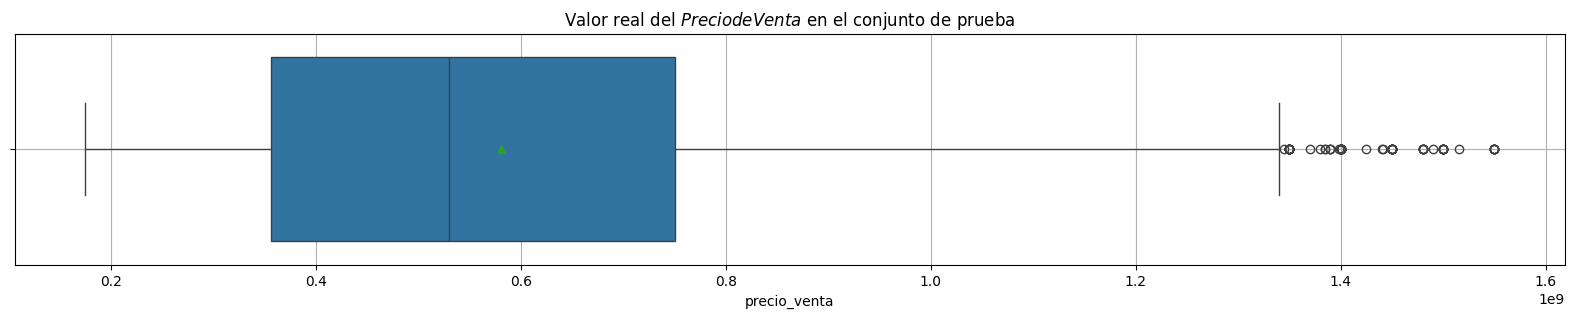

In [61]:
plt.figure(figsize=(20, 3))
sns.boxplot(x=y_test, showmeans=True, orient="h")
plt.title("Valor real del $\t{Precio de Venta}$ en el conjunto de prueba")
plt.grid()
plt.show()

In [62]:
y_test.describe(percentiles=[0.25, 0.5, 0.75, 0.99])

count         4528.00
mean     581011110.37
std      287108832.96
min      175000000.00
25%      356000000.00
50%      530000000.00
75%      750000000.00
99%     1400000000.00
max     1550000000.00
Name: precio_venta, dtype: float64

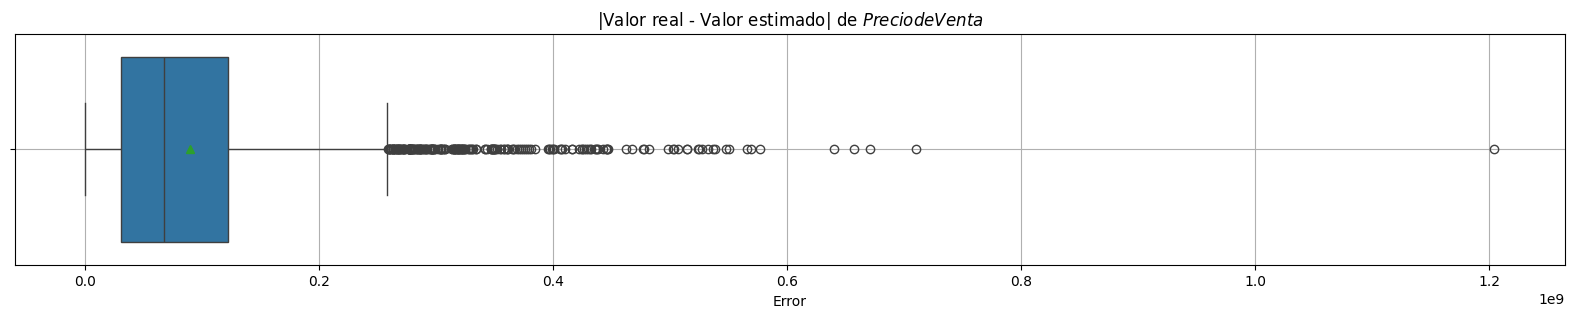

In [63]:
plt.figure(figsize=(20, 3))
sns.boxplot(x=abs(y_test - regression.predict(X_test)), showmeans=True, orient="h")
plt.title("|Valor real - Valor estimado| de $\t{Precio de Venta}$")
plt.xlabel("Error")
plt.grid()
plt.show()

In [64]:
abs(y_test-regression.predict(X_test)).describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99])

count         4528.00
mean      89712114.48
std       85480633.91
min          40077.81
25%       30439136.57
50%       67090495.29
75%      121860820.07
95%      252728871.24
99%      414467484.28
max     1204290911.01
Name: precio_venta, dtype: float64

## **6. Entrenamiento de un segundo modelo aplicando normalización**

In [65]:
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]
)

In [66]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

In [67]:
pd.DataFrame({"columns": features, "coef": pipeline["model"].coef_})

columns         coef
0                      area 165215491.09
1              habitaciones -29584715.84
2                     banos  20503467.28
3            administracion  54480170.26
4              parqueaderos  32768085.99
5                   estrato  32058370.16
6                   jacuzzi   1632009.24
7                  chimenea         0.00
8          permite_mascotas         0.00
9                  gimnasio  19159674.93
10                 ascensor    293852.83
11                  piscina   7724075.98
12            salon_comunal         0.00
13                  terraza    430885.43
14               vigilancia   2038834.70
15  distancia_estacion_tm_m  -9354102.02
16       distancia_parque_m   3908157.44
17          is_cerca_parque   7944001.41
18         conjunto_cerrado  -2690247.86
19           tipo_propiedad         0.00
20                   sector   8403704.05
21               antiguedad -42538608.94
22                   estado   -973101.27
23                localidad -37219722.56
24                 compañia  -2185505.94
25                   barrio  -4515599.64
26      estacion_tm_cercana   1418705.03
27           parque_cercano  -2827461.48

In [68]:
pipeline["model"].intercept_

580572383.9717937

In [69]:
y_train.mean(), y_test.mean()

(580572383.9717937, 581011110.3657243)

In [70]:
print("MAE:")
print("Train:", mean_absolute_error(y_train, pipeline.predict(X_train)))
print("Test:", mean_absolute_error(y_test, pipeline.predict(X_test)))
print("\nRMSE:")
print("Train:", np.sqrt(mean_squared_error(y_train, pipeline.predict(X_train))))
print("Test:", np.sqrt(mean_squared_error(y_test, pipeline.predict(X_test))))

MAE:
Train: 88070013.5095362
Test: 89712114.48198275

RMSE:
Train: 121284146.11280267
Test: 123909598.24036252


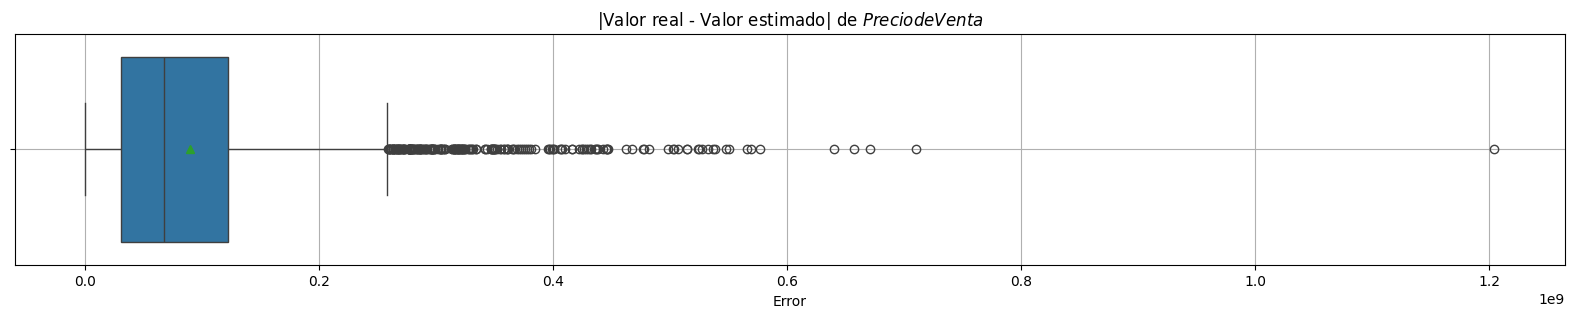

In [71]:
plt.figure(figsize=(20, 3))
sns.boxplot(x=abs(y_test - pipeline.predict(X_test)), showmeans=True, orient="h")
plt.title("|Valor real - Valor estimado| de $\t{Precio de Venta}$")
plt.xlabel("Error")
plt.grid()
plt.show()

In [72]:
abs(y_test-pipeline.predict(X_test)).describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99])

count         4528.00
mean      89712114.48
std       85480633.91
min          40077.80
25%       30439136.57
50%       67090495.29
75%      121860820.07
95%      252728871.24
99%      414467484.27
max     1204290911.00
Name: precio_venta, dtype: float64

<Axes: >

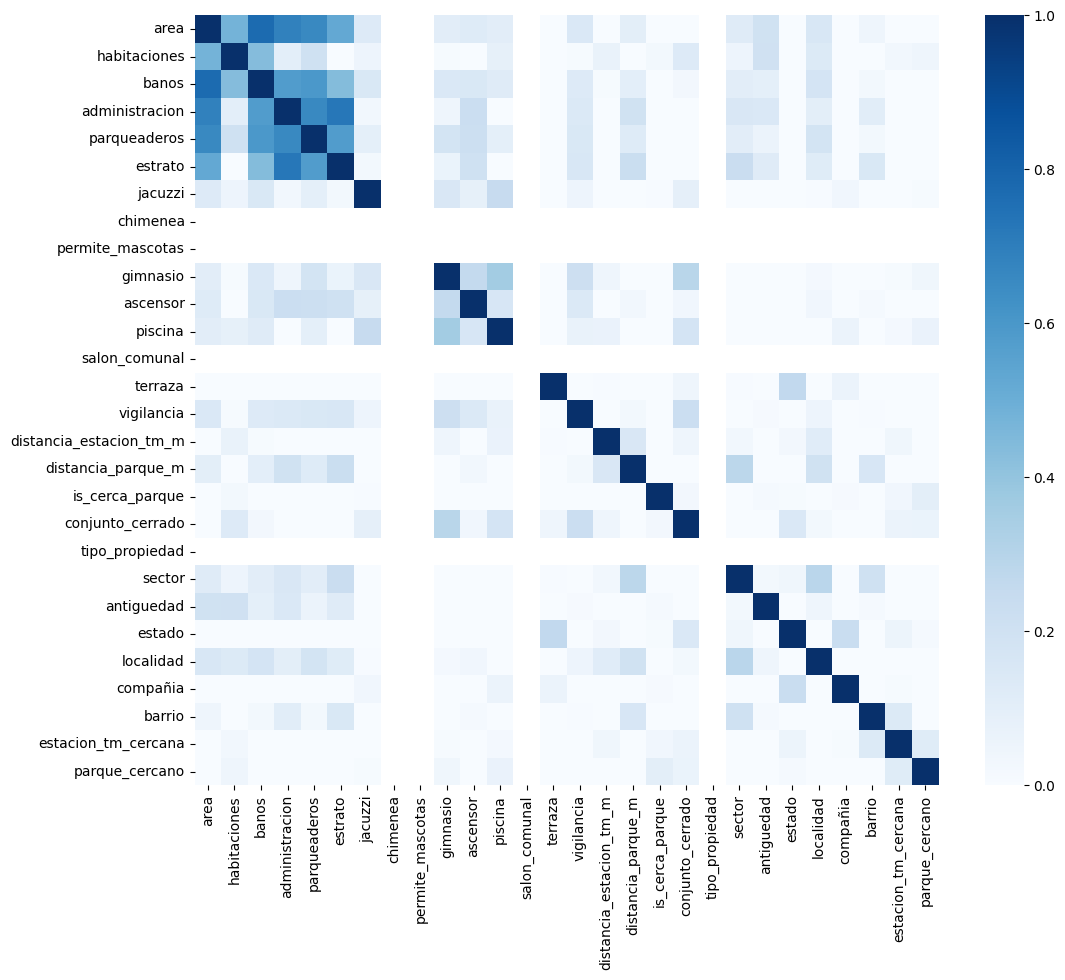

In [73]:
plt.figure(figsize=(12, 10))
sns.heatmap(X_train.corr(), cmap="Blues", vmin=0, vmax=1)

In [74]:
X_train.corr()

area  habitaciones  banos  administracion  \
area                     1.00          0.48   0.77            0.69   
habitaciones             0.48          1.00   0.44            0.10   
banos                    0.77          0.44   1.00            0.58   
administracion           0.69          0.10   0.58            1.00   
parqueaderos             0.66          0.21   0.59            0.66   
estrato                  0.53         -0.10   0.44            0.73   
jacuzzi                  0.13          0.05   0.15            0.03   
chimenea                  NaN           NaN    NaN             NaN   
permite_mascotas          NaN           NaN    NaN             NaN   
gimnasio                 0.11          0.01   0.14            0.05   
ascensor                 0.13         -0.06   0.15            0.22   
piscina                  0.11          0.09   0.12           -0.02   
salon_comunal             NaN           NaN    NaN             NaN   
terraza                 -0.03         -0.01  -0.03           -0.03   
vigilancia               0.14          0.01   0.13            0.14   
distancia_estacion_tm_m -0.00          0.07   0.01           -0.04   
distancia_parque_m       0.10         -0.04   0.10            0.20   
is_cerca_parque         -0.06          0.03  -0.06           -0.09   
conjunto_cerrado        -0.01          0.13   0.03           -0.13   
tipo_propiedad            NaN           NaN    NaN             NaN   
sector                   0.12          0.05   0.11            0.16   
antiguedad               0.20          0.20   0.10            0.15   
estado                  -0.14         -0.00  -0.12           -0.16   
localidad                0.16          0.14   0.18            0.10   
compañia                -0.12         -0.01  -0.10           -0.14   
barrio                   0.05         -0.06   0.03            0.11   
estacion_tm_cercana     -0.11          0.03  -0.11           -0.15   
parque_cercano          -0.08          0.05  -0.08           -0.13   

                         parqueaderos  estrato  jacuzzi  chimenea  \
area                             0.66     0.53     0.13       NaN   
habitaciones                     0.21    -0.10     0.05       NaN   
banos                            0.59     0.44     0.15       NaN   
administracion                   0.66     0.73     0.03       NaN   
parqueaderos                     1.00     0.58     0.10       NaN   
estrato                          0.58     1.00     0.02       NaN   
jacuzzi                          0.10     0.02     1.00       NaN   
chimenea                          NaN      NaN      NaN       NaN   
permite_mascotas                  NaN      NaN      NaN       NaN   
gimnasio                         0.18     0.06     0.15       NaN   
ascensor                         0.22     0.21     0.09       NaN   
piscina                          0.09    -0.02     0.25       NaN   
salon_comunal                     NaN      NaN      NaN       NaN   
terraza                         -0.04    -0.03    -0.01       NaN   
vigilancia                       0.15     0.16     0.05       NaN   
distancia_estacion_tm_m         -0.03    -0.02     0.00       NaN   
distancia_parque_m               0.13     0.23    -0.01       NaN   
is_cerca_parque                 -0.07    -0.12     0.01       NaN   
conjunto_cerrado                -0.04    -0.16     0.09       NaN   
tipo_propiedad                    NaN      NaN      NaN       NaN   
sector                           0.11     0.23    -0.02       NaN   
antiguedad                       0.06     0.12    -0.07       NaN   
estado                          -0.19    -0.18    -0.03       NaN   
localidad                        0.18     0.12     0.00       NaN   
compañia                        -0.13    -0.16     0.04       NaN   
barrio                           0.03     0.15    -0.00       NaN   
estacion_tm_cercana             -0.15    -0.14    -0.01       NaN   
parque_cercano                  -0.09    -0.16     0.01       

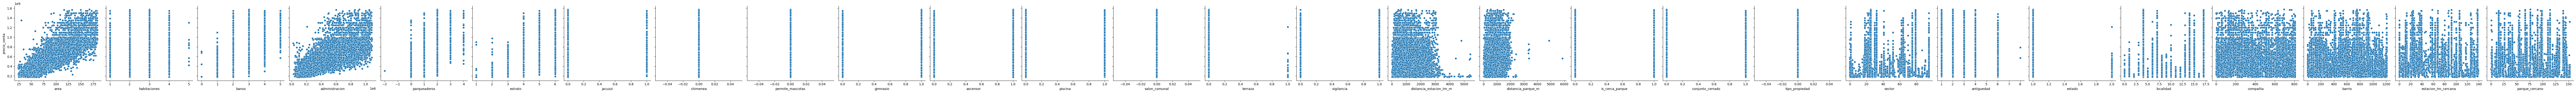

In [75]:
sns.pairplot(pd.concat([X_train, y_train], axis=1), height=4, y_vars="precio_venta", x_vars=features, kind="scatter")

PRUEBAS

In [ ]:
regression.fit(X_train, y_train)

In [108]:
model = sm.OLS(y_train, X_train).fit()

# Extract coefficients, standard errors, and absolute t-values
results = pd.DataFrame({
    'Coefficient': model.params,
    'SE': model.bse,
    '|t|': abs(model.tvalues)
})

# Display the results
print(results.sort_values(by='|t|', ascending=False))

                         Coefficient          SE   |t|
area                      4543778.13    66531.99 68.29
antiguedad              -32900700.66  1040080.24 31.63
localidad                -7026191.73   257341.69 27.30
administracion                205.24        8.27 24.82
estrato                  34444331.35  1604870.15 21.46
parqueaderos             44139289.82  2448941.68 18.02
habitaciones            -36130228.04  2096125.69 17.24
gimnasio                 42509736.99  3087973.93 13.77
banos                    25046424.97  2306023.68 10.86
distancia_estacion_tm_m    -11123.99     1571.76  7.08
is_cerca_parque          23135176.86  3652287.78  6.33
piscina                  26524955.76  4521028.61  5.87
sector                     305068.14    52367.42  5.83
estado                   26270995.91  6354753.07  4.13
distancia_parque_m          14493.30     4061.23  3.57
barrio                     -11332.76     3798.19  2.98
vigilancia                6466854.61  2616314.26  2.47
conjunto_c

In [118]:
results.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28 entries, area to parque_cercano
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Coefficient  28 non-null     float64
 1   SE           28 non-null     float64
 2   |t|          28 non-null     float64
dtypes: float64(3)
memory usage: 1.9+ KB


In [116]:
results['SE'].shape
results['Coefficient'].shape
results.index.shape

(28,)

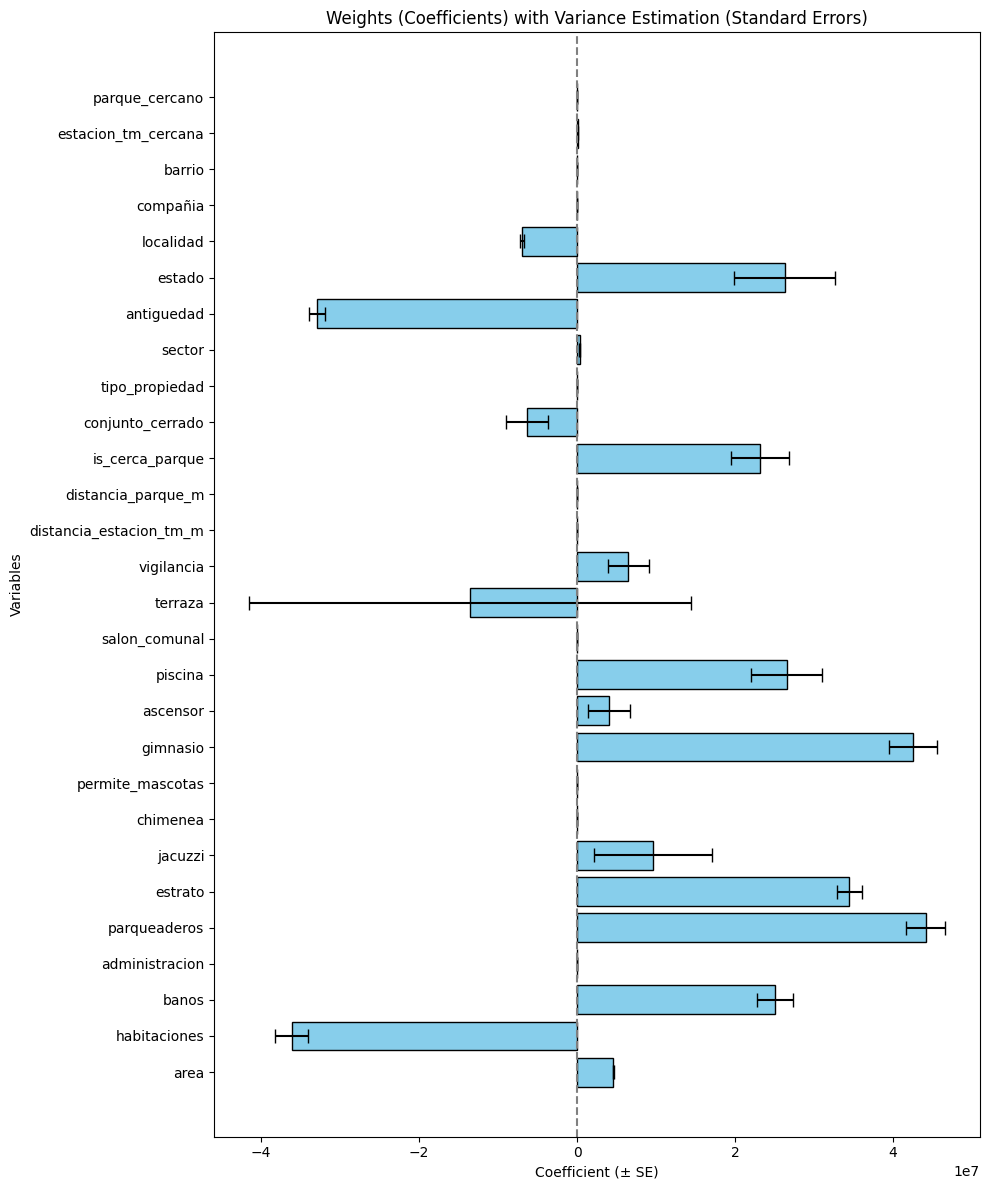

In [123]:
# Plot using plt.barh() for horizontal bars
plt.figure(figsize=(10, 12))
plt.barh(results.index, results['Coefficient'], xerr=results['SE'], capsize=5, color='skyblue', edgecolor='k')

# Add a vertical reference line at 0 for interpreting significance
plt.axvline(0, color='gray', linestyle='--')
plt.ylabel("Variables")
plt.xlabel("Coefficient (± SE)")
plt.title("Weights (Coefficients) with Variance Estimation (Standard Errors)")
plt.tight_layout()
plt.show()

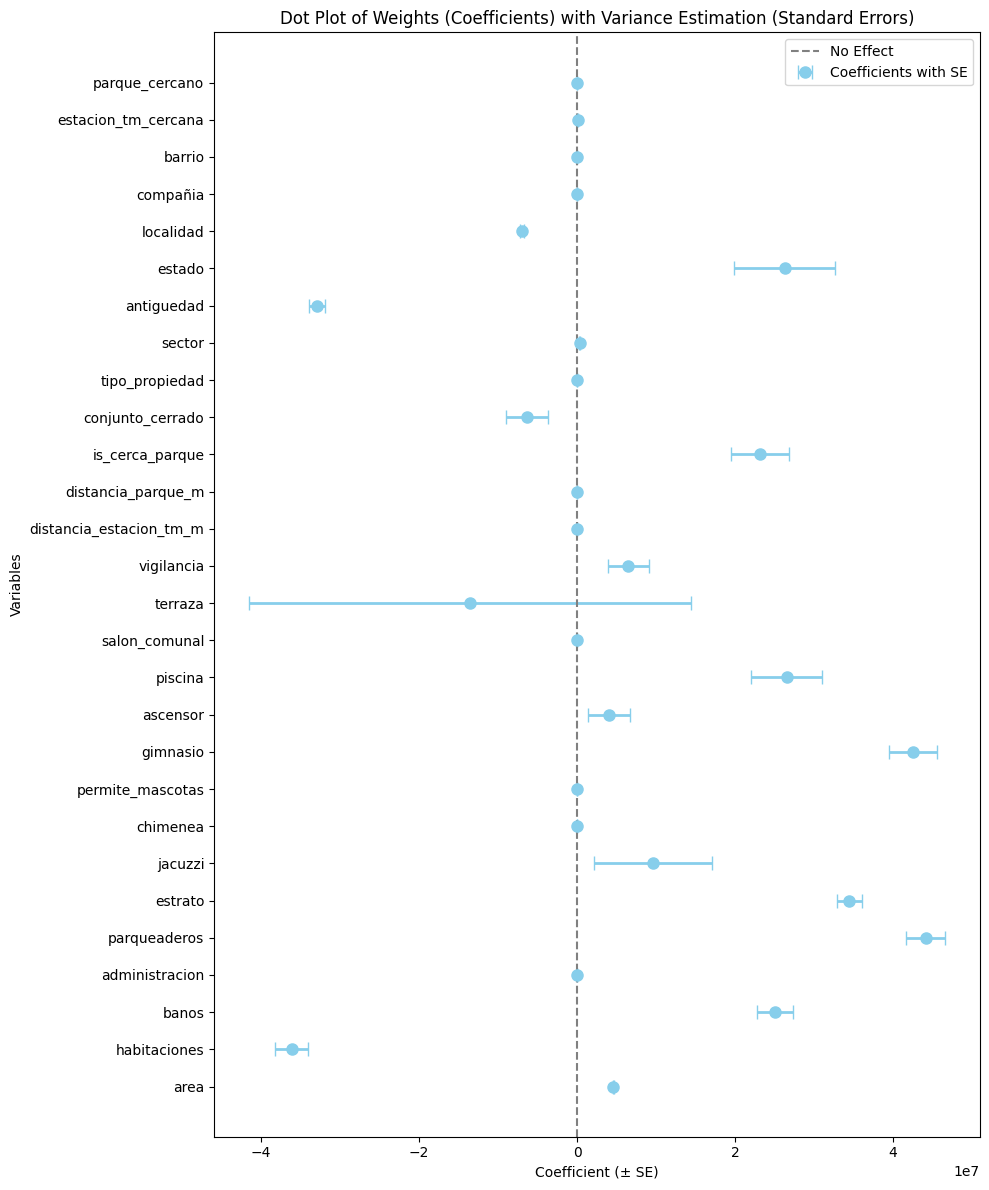

In [124]:
# Create a dot plot
def dot_plot(df):
  plt.figure(figsize=(10, 12))
  plt.errorbar(df['Coefficient'], df.index, xerr=df['SE'], fmt='o', color='skyblue',
              markersize=8, capsize=5, elinewidth=2, label='Coefficients with SE')

  # Add a vertical reference line at 0 for interpreting significance
  plt.axvline(0, color='gray', linestyle='--', label='No Effect')

  # Labels and title
  plt.xlabel("Coefficient (± SE)")
  plt.ylabel("Variables")
  plt.title("Dot Plot of Weights (Coefficients) with Variance Estimation (Standard Errors)")
  plt.legend()
  plt.tight_layout()
  plt.show()

dot_plot(results)

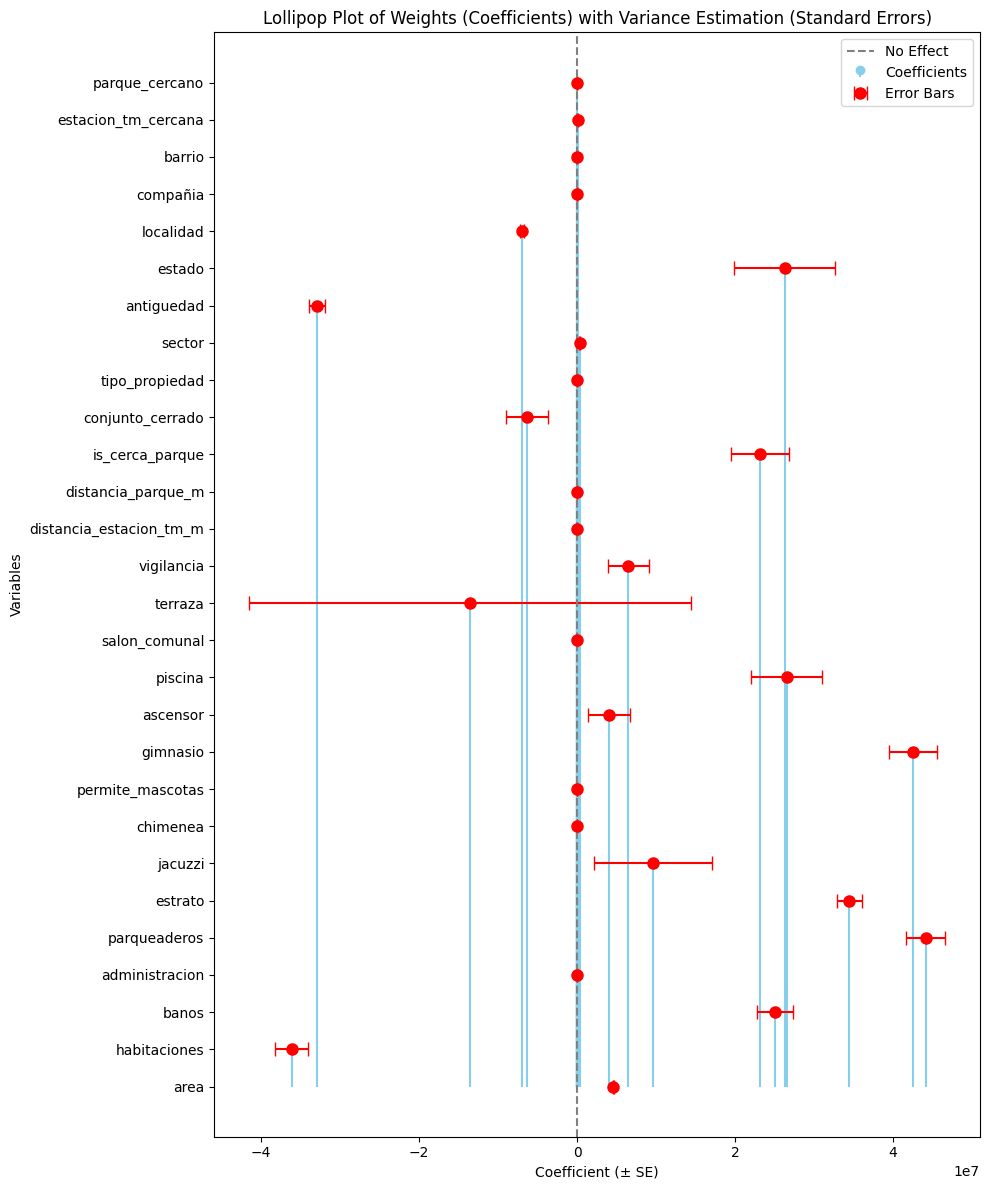

In [125]:
def lollipop_plot(  df):
  plt.figure(figsize=(10, 12))
  plt.stem(df['Coefficient'], df.index, linefmt='skyblue', markerfmt='o', basefmt=" ", label='Coefficients')
  plt.errorbar(df['Coefficient'], df.index, xerr=df['SE'], fmt='o', color='red',
              markersize=8, capsize=5, label='Error Bars')

  # Add a vertical reference line at 0 for interpreting significance
  plt.axvline(0, color='gray', linestyle='--', label='No Effect')

  # Labels and title
  plt.xlabel("Coefficient (± SE)")
  plt.ylabel("Variables")
  plt.title("Lollipop Plot of Weights (Coefficients) with Variance Estimation (Standard Errors)")
  plt.legend()
  plt.tight_layout()
  plt.show()

lollipop_plot(results)

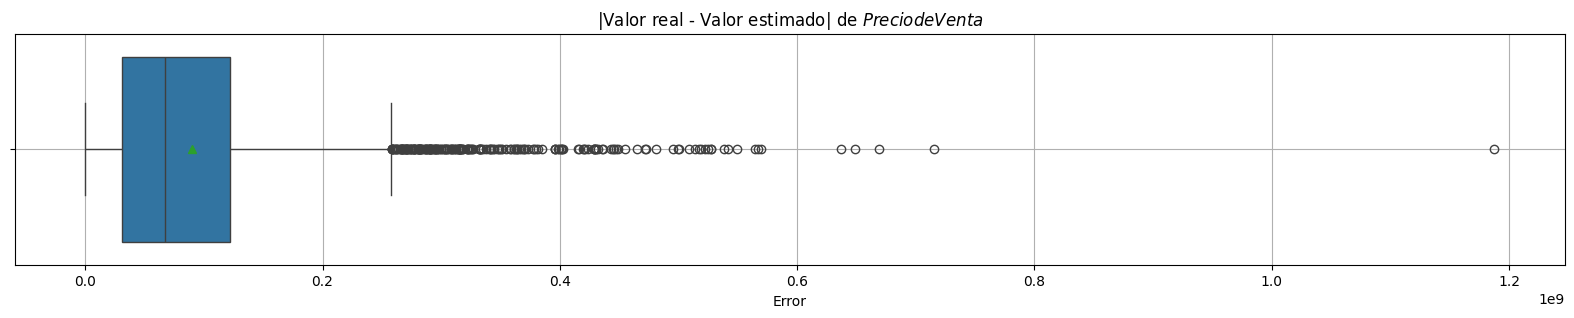

In [105]:
plt.figure(figsize=(20, 3))
sns.boxplot(x=abs(y_test - model.predict(X_test)), showmeans=True, orient="h")
plt.title("|Valor real - Valor estimado| de $\t{Precio de Venta}$")
plt.xlabel("Error")
plt.grid()
plt.show()


In [107]:
abs(y_test-model.predict(X_test)).describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99])

count         4528.00
mean      89801008.46
std       85352732.32
min          56386.07
25%       30573641.69
50%       67574874.95
75%      121642860.26
95%      251078037.94
99%      415965370.10
max     1187713878.00
dtype: float64

In [99]:
regression.se

LinearRegression()

In [104]:
pd.DataFrame({"columns": features, "coef": regression.coef_})

columns         coef
0                      area   4589751.08
1              habitaciones -40271677.56
2                     banos  24268180.05
3            administracion       212.25
4              parqueaderos  44598198.19
5                   estrato  29588884.74
6                   jacuzzi   9809583.00
7                  chimenea        -0.00
8          permite_mascotas         0.00
9                  gimnasio  41685139.76
10                 ascensor    620664.01
11                  piscina  26119118.49
12            salon_comunal         0.00
13                  terraza   9912724.16
14               vigilancia   4128264.60
15  distancia_estacion_tm_m    -11957.63
16       distancia_parque_m      9412.37
17          is_cerca_parque  18321096.88
18         conjunto_cerrado  -5407834.83
19           tipo_propiedad        -0.00
20                   sector    331146.43
21               antiguedad -33780134.53
22                   estado  -6016593.76
23                localidad  -7337325.34
24                 compañia     -8399.79
25                   barrio    -13788.28
26      estacion_tm_cercana     35119.58
27           parque_cercano    -71206.54

In [98]:
#pd.DataFrame({"columns": features, "error":(y_test - regression.predict(X_test))})
y_test - regression.predict(X_test)

27053    57148575.14
20318   -31202203.99
4448     45647821.40
760     -62930259.68
6759    -28139054.37
            ...     
28691    28731974.42
34769    51484703.28
19865    17603272.34
35743   100042720.52
10232   144549184.69
Name: precio_venta, Length: 4528, dtype: float64

In [88]:
#coeficientes = regression.params
errores_estandar = regression.bse

# Calcular la estadística t
estadistica_t = coeficientes / errores_estandar

AttributeError: 'LinearRegression' object has no attribute 'bse'